In [15]:
'''
Loading libs
'''
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [93]:
'''
Setup parameters
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

content_filepath = './images/mariya.jpg'
style_filepath = './images/tumblr_oyx3epCaCo1v5wtjuo1_1280.jpg'

img_size = (512,512) if torch.cuda.is_available() else (128,128)

In [94]:
'''
Load images
'''
transform = transforms.Compose([
    transforms.Resize(img_size), # scale image
    transforms.ToTensor() # PIL image -> tensor
])

def image_loader(image_path):
    image = Image.open(image_path)
    # fake batch dimention required to fit network's input dimentions
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader(content_filepath)
style_img = image_loader(style_filepath)

assert style_img.size() == content_img.size(), \
    'we need to import style and content images of the same size'

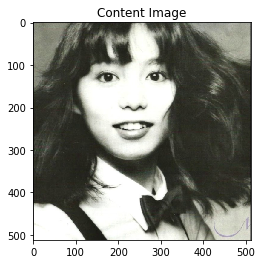

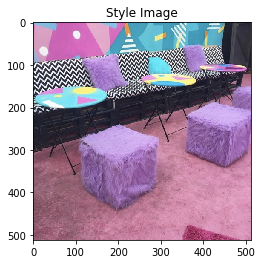

In [95]:
'''
Show images
'''
untransform = transforms.ToPILImage() # tensor -> PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = untransform(image)

    plt.figure()
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(1e-3)
    
plt.ion()

imshow(content_img, 'Content Image')
imshow(style_img, 'Style Image')

### How the Transfer works
We have 2 images image_1 and image_2, content and style respectively.  
We have 2 feature spaces: `content feature space` and `style feature space`    
We can translate our images into each of this spaces, and calculate distance between them in feature space.  
Than we take therd image and try to place it as close to our content and style images in bouth feature spaces as close as possible.  
Distance between 2 images in `content` space: $D_C$  
Distance between 2 images in `style` space: $D_S$  


`Content loss` - function that returns weighted version of the content distance for a individual layer (in content space).  
the function takes the feature maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the weighted content distance $w_{CL}\cdot D_C^L(X,C)$ between the image $X$ and content image $C$

In [96]:
'''
Define Content loss
'''
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach() # use as a value, not a variable
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    

`Style loss` - 

In [97]:
'''
Define Style loss
'''
def gram_matrix(input):
    a,b,c,d = input.size() 
    # a = batch size (=1)
    # b = number of feature maps
    # c, d = dimentions of a feature map
    
    # Vectorization
    features = input.view(a * b, c * d) 
    
    # Compute Gram product
    G = torch.mm(features, features.t())
    
    # Normalization
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [98]:
'''
Define model
'''
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [99]:
'''
Normalizers for vgg19
'''
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

In [100]:
'''
Put content and style loss after conv layer in the model
'''
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img,
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    # track losses
    content_losses = []
    style_losses = []
    
    # assuming that cnn is nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    
    i = 0 # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)
        
        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{}'.format(i), style_loss)
            style_losses.append(style_loss)
            
    # trim off the layers after the last content and style losses
    for i in range(len(model)-1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i+1)]

    return model, style_losses, content_losses
            

<Figure size 432x288 with 0 Axes>

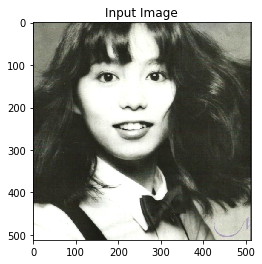

In [101]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [102]:
'''
Gradient Descent
'''
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [103]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                      content_img, style_img, input_img, n_steps=300,
                      style_weight=1e+5, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing...')
    run = [0]
    while run[0] <= n_steps:
        
        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0,1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 100 == 0:
                print('run {}:'.format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}'
                      .format(style_score.item(), content_score.item()))
            return style_score + content_score
        
        optimizer.step(closure)
        
    # last correction
    input_img.data.clamp_(0,1)
    return input_img
            

In [104]:
'''
Rum the algorithm
'''
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                           content_img, style_img, input_img,
                           n_steps=500, style_weight=1e+5, content_weight=1)

Building the style transfer model...
Optimizing...


/home/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/home/ivan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [100]:
Style Loss: 6.832458 Content Loss: 13.993759
run [200]:
Style Loss: 2.271398 Content Loss: 12.178727
run [300]:
Style Loss: 1.588273 Content Loss: 11.609087
run [400]:
Style Loss: 2.439888 Content Loss: 11.909192
run [500]:
Style Loss: 13.144241 Content Loss: 11.031344


<Figure size 432x288 with 0 Axes>

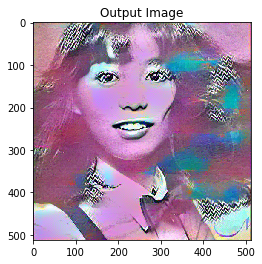

In [108]:
plt.figure()
imshow(output, title='Output Image')